In [25]:
# VAE local devel, r5
r = 'r5'

In [7]:
import pandas as pd
import glob

In [3]:
ls ../results/input-data/r5/r5-fls

AML_proteomics_cell-line+BeatAML.tsv
AML_transcriptomics_cell-line+BeatAML.tsv
brain_transcriptomics_CPTAC+HCMI.tsv
breast-ductal_proteomics_cell-line+CPTAC.tsv
breast-lobular_transcriptomics_cell-line+CPTAC.tsv
breast_transcriptomics_CPTAC+HCMI.tsv
colon-adeno_proteomics_cell-line+CPTAC.tsv
colon-adeno_transcriptomics_cell-line+CPTAC.tsv
colon_transcriptomics_CPTAC+HCMI.tsv
colon_transcriptomics_cell-line+HCMI.tsv
esophogeal_transcriptomics_cell-line+HCMI.tsv
glioblastoma_proteomics_cell-line+CPTAC.tsv
glioblastoma_transcriptomics_cell-line+CPTAC.tsv
head-neck_transcriptomics_cell-line+CPTAC.tsv
lung-ad_transcriptomics_CPTAC+HCMI.tsv
lung-adeno_proteomics_cell-line+CPTAC.tsv
lung-adeno_transcriptomics_cell-line+CPTAC.tsv
lung-sq_transcriptomics_CPTAC+HCMI.tsv
ovarian_transcriptomics_CPTAC+HCMI.tsv
pancreas_transcriptomics_cell-line+HCMI.tsv
pancreatic-adeno_proteomics_cell-line+CPTAC.tsv
pancreatic-adeno_transcriptomics_cell-line+CPTAC.tsv
pancreatic_transcriptomics_CPTAC+HCMI.tsv
ren

In [8]:
n_25 = sorted(glob.glob('../results/input-data/r5/r5-fls/*'))

#### VAE setup

In [4]:
import math
import collections

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
# VAE functions
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(
            x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [36]:
# Loss plot visualization to determine degree of model fitting
def plot_loss(loss_dict, data_type, train_file):

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot loss values
    plt.plot(loss_dict['vs0'], marker='o', linestyle='-', color='b')

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add titles and labels
    plt.title('CPTAC '+data_type+' VAE Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    # Annotation for epochs and latent dimension
    plt.annotate('Samples: {}'.format(len(train_file))+'\nLatent dim: 250\nRaw features: {}'.format(len(train_file.columns)), 
                 xy=(0.7, 0.3), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='black'),
                 fontsize=12)

    # Save the plot
    plt.savefig(#'loss_plots/'+data_type+'_vae_loss.png'
               '../results/vae-out/'+r+
                         '/'+r+'-fls/'+cancer+'_'+modality+'_'+
                         systems+'_vae_loss.png')
    # plt.close()  # Close the figure - not for interactive devel / demo

#### Load data and run VAE

In [27]:
fl_pth.split('_')

['../results/input-data/r5/r5-fls/AML', 'proteomics', 'cell-line+BeatAML.tsv']

../results/input-data/r5/r5-fls/AML_proteomics_cell-line+BeatAML.tsv
Train on 220 samples
Epoch 1/8
220/220 [==============================] - 0s 1ms/sample - loss: 4008.0738
Epoch 2/8
220/220 [==============================] - 0s 183us/sample - loss: 3928.9295
Epoch 3/8
220/220 [==============================] - 0s 191us/sample - loss: 3870.6259
Epoch 4/8
220/220 [==============================] - 0s 185us/sample - loss: 3832.9535
Epoch 5/8
220/220 [==============================] - 0s 184us/sample - loss: 3811.3950
Epoch 6/8
220/220 [==============================] - 0s 193us/sample - loss: 3794.0966
Epoch 7/8
220/220 [==============================] - 0s 189us/sample - loss: 3781.4678
Epoch 8/8
220/220 [==============================] - 0s 198us/sample - loss: 3771.2018
VAE done, latent object and loss plot written to disk


/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


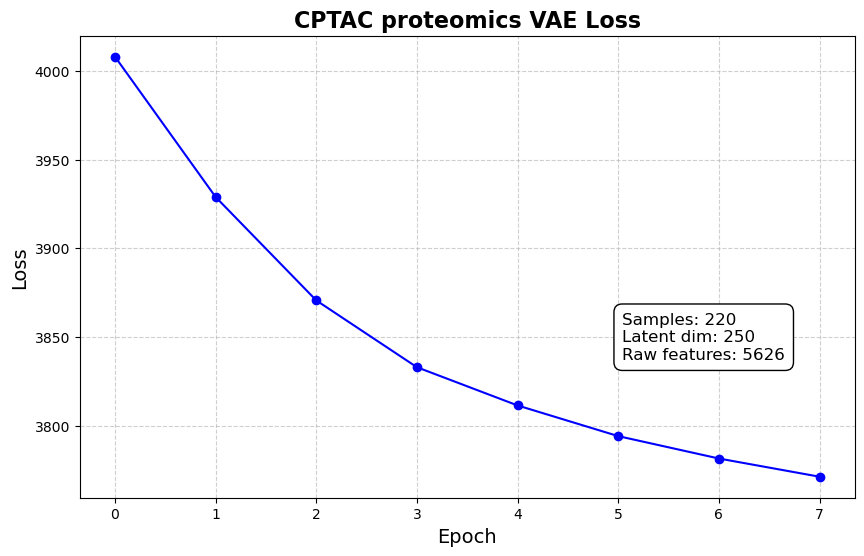

In [41]:
epochs = 8
for fl_pth in n_25:
    print(fl_pth)
    cancer = fl_pth.split('_')[0].split('/')[-1]
    modality = fl_pth.split('_')[1]
    systems = fl_pth.split('_')[2].split('.')[0]
    latent_header_prefix = data_type[:4]
    train_file = pd.read_csv(fl_pth,
                        sep = '\t', index_col = 0)
    sys_lbls = train_file.System
    cncr_lbls = train_file.Cancer_type
    train_file = train_file.iloc[:, 2:]

    # Normalize
    scaler = MinMaxScaler()
    train_file = pd.DataFrame(
        scaler.fit_transform(train_file),
        columns=train_file.columns,
        index=train_file.index)
    # break
    # Variational auto-encoder, Tybalt
    loss_dict = {}
    vs_list = ['vs0']
    validation_split = vs_list[0]
    
    features = train_file.columns
    
    original_dim = len(features)
    feature_dim = len(features)
    latent_dim = 250
    batch_size = 50
    
    encoder_inputs = keras.Input(shape=(feature_dim,))
    z_mean_dense_linear = layers.Dense(
        latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
    z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
    z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)
    
    z_log_var_dense_linear = layers.Dense(
        latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
    z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
    z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)
    
    latent_space = layers.Lambda(
        compute_latent, output_shape=(
            latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])
    
    decoder_to_reconstruct = layers.Dense(
        feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
    decoder_outputs = decoder_to_reconstruct(latent_space)
    
    learning_rate = 0.0005
    
    kappa = 1
    beta = K.variable(0)
    
    adam = optimizers.Adam(learning_rate=learning_rate)
    vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
    vae = Model(encoder_inputs, vae_layer)
    vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
    
    history = vae.fit(train_file,
                epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      callbacks=[WarmUpCallback(beta, kappa)],
                      verbose=1)
    loss_dict[validation_split] = history.history['loss']
    
    encoder = Model(encoder_inputs, z_mean_encoded)
    latent_object = pd.DataFrame(
        encoder.predict(train_file),
        index=train_file.index
    )
    latent_object.index.name = train_file.index.name
    # break
    # Convert latent object headers to dtype specific strings for input to transformer
    new_column_headers = []
    for column_header in latent_object.columns:
        # latent_header_prefix
        new_column_header = latent_header_prefix+'_' + str(column_header)
        new_column_headers.append(new_column_header)
    latent_object.columns = new_column_headers
    
    latent_object.to_csv('../results/vae-out/'+r+
                         '/'+r+'-fls/'+cancer+'_'+modality+'_'+
                         systems+'_ltnt.tsv', sep = '\t')
    plot_loss(loss_dict, data_type, train_file)
    print('VAE done, latent object and loss plot written to disk')
    break

In [34]:
plot_loss(loss_dict, data_type, train_file)

'prot'

#### TF cos sim

https://www.tensorflow.org/api_docs/python/tf/keras/losses/cosine_similarity

In [1]:
import tensorflow as tf

In [ ]:
tf.keras.losses.cosine_similarity(
    y_true, y_pred, axis=-1
)

#### MMD

In [ ]:
# MMD function, lower score is better
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
def compute_mmd(gexp_1, gexp_2, gamma=1.0):
    K_XX = rbf_kernel(gexp_1, gexp_1, gamma=gamma)
    K_XY = rbf_kernel(gexp_1, gexp_2, gamma=gamma)
    K_YY = rbf_kernel(gexp_2, gexp_2, gamma=gamma)

    m = gexp_1.shape[0]
    n = gexp_2.shape[0]

    mmd = (np.sum(K_XX) - np.trace(K_XX)) / (m * (m - 1))
    mmd += (np.sum(K_YY) - np.trace(K_YY)) / (n * (n - 1))
    mmd -= 2 * np.sum(K_XY) / (m * n)

    # Ensure the MMD value is non-negative
    mmd = np.maximum(mmd, 0)

    return np.sqrt(mmd)

##### MMD front-end

In [ ]:
# call on ../output/sng-cncr/cell_line_beatAML_transcriptomics.tsv

##### MMD on latent

##### MMD on mbatch out

#### Scikit-learn

#### UMAP

#### default model ops

In [ ]:
# Call sig, native macos terminal
# generate vae latent obj

#### devel notes

In [ ]:
# MAD

In [ ]:
# VAE

In [ ]:
https://github.com/PNNL-CompBio/panCancerModelSystems/blob/main/CPTAC_VAE_v0.ipynb

In [ ]:
# Link to transformer example

In [ ]:
https://github.com/PNNL-CompBio/panCancerModelSystems/blob/main/CPTAC_trnsfrmr_v0.ipynb